# ライブラリの読み込み

In [1]:
#!pip install threadpoolctl==3.1.0  #t-sneでエラーがでる場合の対処   https://github.com/scikit-learn/scikit-learn/issues/24238
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt 
import matplotlib as mpl 
mpl.rcParams['font.family'] = 'MS Gothic'
mpl.rcParams['font.size'] = 14
mpl.rcParams['figure.figsize'] = [10, 10]

In [2]:
df = pd.read_csv('../data/delaney-solubility/delaney-processed.csv')
df

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.770,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.300,Cc1occc1C(=O)Nc2ccccc2
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.060,CC(C)=CCCC(C)=CC(=O)
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.870,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.330,c1ccsc1
...,...,...,...,...,...,...,...,...,...,...
1123,halothane,-2.608,1,197.381,0,0,0,0.00,-1.710,FC(F)(F)C(Cl)Br
1124,Oxamyl,-0.908,1,219.266,1,0,1,71.00,0.106,CNC(=O)ON=C(SC)C(=O)N(C)C
1125,Thiometon,-3.323,1,246.359,0,0,7,18.46,-3.091,CCSCCSP(=S)(OC)OC
1126,2-Methylbutane,-2.245,1,72.151,0,0,1,0.00,-3.180,CCC(C)C


# 構造データの多様性を確認

In [3]:
# 距離計算モジュール
from scipy.spatial.distance import (pdist, cdist, squareform)
from scipy.sparse import csr_matrix
from rdkit import Chem 
import rdkit 
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect

In [4]:
df['mol'] = df['smiles'].apply(Chem.MolFromSmiles)

In [5]:
X = np.matrix([GetMorganFingerprintAsBitVect(m, radius=3, nBits=256)
              for m in df['mol']])

In [6]:
X
# pdistあるいはcdistを使うことでサンプル同士の
# 類似度を網羅的に計算

matrix([[1, 1, 1, ..., 1, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 1],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 1]])

In [7]:
D = squareform(pdist(X, 'jaccard'))

In [8]:
D.shape

(1128, 1128)

## タニモト係数

('Jaccard係数'とも呼ばれる)

$$
  c_{\rm Tanimoto}(A,B) = \frac{\#\{A \cap B\}}{\#\{A \cup B\}} 
$$

AとBの和集合の要素数を、AとBの積集合の要素数で
割ったものがタニモト係数。

In [11]:
from scipy.spatial import distance 
distance.jaccard([1, 0, 0], [1, 0, 0])# jaccard distanceを用いているので、自分同士の距離は0

0.0

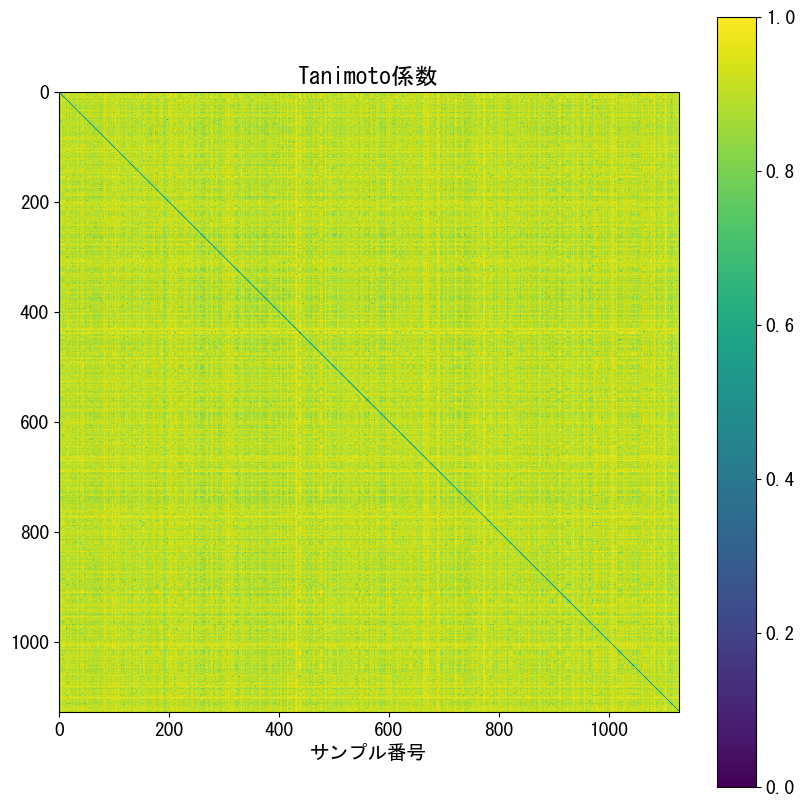

In [10]:
plt.imshow(D)
plt.colorbar()

plt.title('Tanimoto係数')
plt.xlabel('サンプル番号')

plt.savefig('../results/eda/tanimotocoef.png')

plt.show()

In [12]:
# 可視化
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=66)
T = tsne.fit_transform(D)

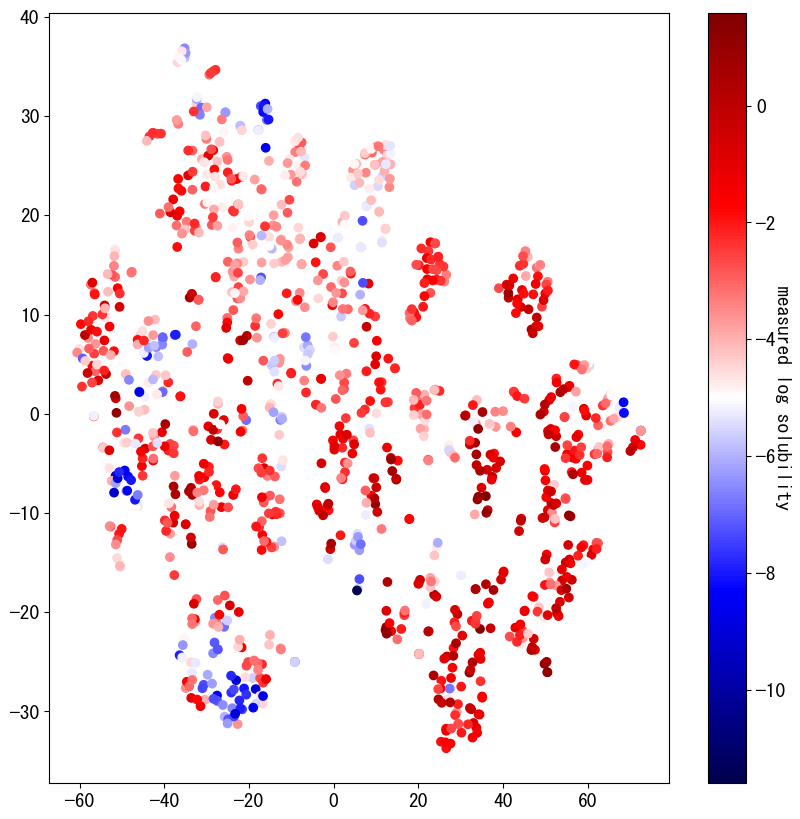

In [13]:
y = df['measured log solubility in mols per litre'].values
plt.scatter(T[:,0],T[:,1], c=y, cmap=plt.cm.seismic)
cbar = plt.colorbar()
cbar.set_label('measured log solubility', rotation = 270)
plt.savefig('../results/eda/tsne_result_logS.png')
plt.show()

## 考察例

1. Tanimoto係数で似ているとされている構造でも、log水溶解度は必ずしも近くならない
1. また、クラスターは特に出来ていないため、データを分ける必要はなさそう